# "Fine-tuning a Norwegian language model for ULMFiT"
> "In this post we'll load a pretrained language model and fine tune it on our target corpus of TV and movie reviews."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [NLP, fastai, LSTM, ULMFiT]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
from fastai2.text.all import *

# ULMFiT recap

In a previous post we explored the [Norec](https://github.com/ltgoslo/norec) Norwegian language corpus of film and TV reviews. In this post I want to use the [ULMFiT](https://nlp.fast.ai/classification/2018/05/15/introducing-ulmfit.html) method to predict the sentiment of the reviews based on the text. ULMFiT has three main steps:
1. Train a language model on a large general purpose corpus such as Wikipedia
1. Fine-tune the language model on the text your are working with - the style is most likely different than a Wikipedia article
1. Use the encoder of the fine-tuned language to transform text to feature vectors, and finally add a linear classifier on top to predict the class of the review.

In this post we'll focus on step 1 and 2, the language model and the fine-tuning. Training a language model from scratch is a bit of work. First you have to get the data to train it, and the training will also take a long time. Luckily the the fast.ai [language model zoo](https://forums.fast.ai/t/language-model-zoo-gorilla/14623) already lists a pretrained language model for Norwegian. Note that this is a ULMFiT model zoo, so we expect to find weights for a [AWD-LSTM](https://arxiv.org/abs/1708.02182). See [this post](https://hallvagi.github.io/dl-explorer/nlp/fastai/rnn/lstm/2020/04/17/AWD_LSTM.html) to better understand how to customize an AWD-LSTM with fastai.

Let's first grab the dataset from a [previous post](https://hallvagi.github.io/dl-explorer/nlp/fastai/2020/04/06/get-data.html). It's available as a csv from github:

In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/hallvagi/dl-explorer/master/uploads/norec.csv')
df.head(3)

,filename,rating,title,split,sentiment,text
0,html/train/000000.html,6,Rome S02,train,positive,"Den andre og siste sesongen av Rome er ute på DVD i Norge. Om du så sesong 1, vet du at du har noe stort i vente. Har du aldri sett Rome før, stikk ut og kjøp begge sesongene. Dette er nemlig en av verdens beste tv-serier, og etter å ha sett de fire første episodene av sesong 2, konstaterer jeg at kvaliteten ser ut til å holde seg på et nesten overraskende høyt nivå! Sesong 2 starter nøyaktig der sesong 1 sluttet. Julius Cæsar ligger myrdet i Senatet og Lucius Vorenus hulker over liket av Neobie. Så blir historien enda mørkere. Marcus Antonius tar over styringen av Roma, men utfordres fra ..."
1,html/train/000001.html,6,Twin Peaks - definitive gold box edition,train,positive,"Tv-serien Twin Peaks, skapt av David Lynch og Mark Frost, trollbandt publikum på starten av 1990-tallet. Nå er begge sesongene samlet på DVD i en såkalt ”definitive gold box edition” som viser at serien ikke har mistet noe av appellen. Det eneste som egentlig røper alderen, er at serien ikke er i widescreen, og at flere av skuespillerne fremdeles er unge og vakre. 17 år etter premieren har de falmet, som mennesker gjør, men Twin Peaks sikrer dem evig liv. Serien handler om et mordmysterium i den lille byen Twin Peaks, et sted langs USAs grense til Canada. Unge, vakre Laura Palmer blir funn..."
2,html/train/000002.html,6,The Wire (sesong 1-4),train,positive,"I neste uke kommer sesong 5 av tv-serien ”The Wire” på DVD. 2008 har for meg vært sterkt preget av denne serien. Hjemme hos oss begynte vi med sesong 1 i vår. Da hadde jeg i lengre tid hørt panegyriske lovord om serien fra både venner og media. Vi ble også fanget av skildringene av purk og skurk i Baltimore, og pløyde oss igjennom alt til og med sesong 4 på sensommeren. Jeg vil ikke gå så langt som å kalle det ”verdens beste serie”, som noen har gjort, men det er ingen tvil om at dette er noe av det bedre som er blitt vist på tv! Serien forteller om en gruppe politietterforskere som samles..."


# Downloading weights

The pretrained weights we want to use is located in this [repo](https://github.com/mollerhoj/Scandinavian-ULMFiT). There is some information listed here:
* The weights were trained on 90% of all text in the corresponding language wikipedia as per 3. July 2018. The remaining 10% was used for validation.
* Norwegian: Trained on 80,284,231 tokens, and validated on 8,920,387 tokens. We achieve a perplexity of 26.31

And file descriptions:
* enc.h5 Contains the weights in 'Hierarchical Data Format'
* enc.pth Contains the weights in 'Pytorch model format'
* itos.pkl (Integers to Strings) contains the vocabulary mapping from ids (0 - 30000) to strings

It looks like we will need the enc.pth (fastai is built on top of PyTorch) and the vocabulary (itos.pkl). But how do we actually load the model? The repo doesn't really specify this part, so let's see if we can figure it out. First we'll download and extract the data to a desired location and have a look at the files:

In [4]:
path = Path('~/.fastai/data/norec') # choses a path of your liking!
os.makedirs(path/'models', exist_ok=True)
model_url = 'https://www.dropbox.com/s/lwr5kvbxri1gvv9/norwegian.zip'
!wget {model_url} -O {path/'models/norwegian.zip'} -q
!unzip -q {path/'models/norwegian.zip'} -d {path/'models'}

In [5]:
Path.BASE_PATH = path # paths are printed relative to the BASE_PATH
(path/'models').ls()

(#5) [Path('models/norwegian_wgts.h5'),Path('models/norwegian_enc.pth'),Path('models/norwegian.zip'),Path('models/norwegian_enc.h5'),Path('models/norwegian_itos.pkl')]

## Vocabulary

The first file we want to check out is the norwegian_itos.pkl. This the vocabulary of the model, that is, the words and tokens it's able to recognize. *itos* means integer-to-string. The index of a particular token in the list is the key to that token.

In [13]:
with open(path/'models/norwegian_itos.pkl', 'rb') as f:
    itos = pickle.load(f)
itos[:10], itos[-5:], len(itos)

(['_unk_', '_pad_', '.', 'i', ',', 'og', '\n\n', 'av', 'som', 'en'],
 ['learning', 'initiativtager', 'forskningsleder', 'devils', 'graeme'],
 30002)

The very first token, i.e. index 0, is \_unk_ or unknown. The other tokens in the first part of the list are common words such as 'i' (in) and 'og' (and). Among the final tokens there are even some English words. This is not really surprising since Norwegian has "borrowed" several words from English. It seems, however, that the special tokens for unknown and padding (\_unk_ and \_pad_) are different than the fastai defaults:

In [6]:
print(defaults.text_spec_tok)

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj']


Will this cause issues later?

## The weights

Secondly, let's have a look at the weights. We'll load it with pyTorch.

In [7]:
enc = torch.load(path/'models/norwegian_enc.pth')
enc.keys()

odict_keys(['encoder.weight', 'encoder_dp.emb.weight', 'rnns.0.weight_hh_l0_raw', 'rnns.0.module.weight_ih_l0', 'rnns.0.module.weight_hh_l0', 'rnns.0.module.bias_ih_l0', 'rnns.0.module.bias_hh_l0', 'rnns.1.weight_hh_l0_raw', 'rnns.1.module.weight_ih_l0', 'rnns.1.module.weight_hh_l0', 'rnns.1.module.bias_ih_l0', 'rnns.1.module.bias_hh_l0', 'rnns.2.weight_hh_l0_raw', 'rnns.2.module.weight_ih_l0', 'rnns.2.module.weight_hh_l0', 'rnns.2.module.bias_ih_l0', 'rnns.2.module.bias_hh_l0'])

It's a dictionary with keys, and the keys are the names of the layers of the model. We can see that is has an embedding layer (named 'encoder'), and three RNNs(LSTMs more precisely) with various descriptions. We recognize the three layer LSTM from the [AWD-LSTM](https://arxiv.org/abs/1708.02182) and the [ULMFiT](https://arxiv.org/abs/1801.06146) paper. So we must make sure that the model we set up matches matches this. Let's have a look at the dimensions of the weights.

In [46]:
for k,v in enc.items():
    print(k," \t", v.shape)

encoder.weight  	 torch.Size([30002, 400])
encoder_dp.emb.weight  	 torch.Size([30002, 400])
rnns.0.weight_hh_l0_raw  	 torch.Size([4600, 1150])
rnns.0.module.weight_ih_l0  	 torch.Size([4600, 400])
rnns.0.module.weight_hh_l0  	 torch.Size([4600, 1150])
rnns.0.module.bias_ih_l0  	 torch.Size([4600])
rnns.0.module.bias_hh_l0  	 torch.Size([4600])
rnns.1.weight_hh_l0_raw  	 torch.Size([4600, 1150])
rnns.1.module.weight_ih_l0  	 torch.Size([4600, 1150])
rnns.1.module.weight_hh_l0  	 torch.Size([4600, 1150])
rnns.1.module.bias_ih_l0  	 torch.Size([4600])
rnns.1.module.bias_hh_l0  	 torch.Size([4600])
rnns.2.weight_hh_l0_raw  	 torch.Size([1600, 400])
rnns.2.module.weight_ih_l0  	 torch.Size([1600, 1150])
rnns.2.module.weight_hh_l0  	 torch.Size([1600, 400])
rnns.2.module.bias_ih_l0  	 torch.Size([1600])
rnns.2.module.bias_hh_l0  	 torch.Size([1600])


We notice that the hidden size is different than the fastai default of 1152, but apart from that everything looks fine. Let's save a few weights from the embedding layer to compare with our final model.

In [47]:
sample_weights = enc['encoder.weight'][0][:5]
sample_weights

tensor([0.5711, 0.2321, 0.2601, 0.9425, 0.0901])

# Load the weights into our model

First we have to make sure that our data loader uses our custom vocabulary instead of doing tokenization on its own, so we pass `text_vocab = itos`. We also set `is_lm = True` since we want a language model and not a classifier. We use the basic factory method, since we have no need of customization at this point.

In [14]:
dls_lm = TextDataLoaders.from_df(df, text_col='text', text_vocab=itos, is_lm=True, valid_pct=0.1)
dls_lm.show_batch(max_n=3)

,text,text_
0,_unk_ _unk_ film : i likhet med _unk_ alejandro _unk_ gonzález _unk_ _unk_ « _unk_ » er _unk_ olivier _unk_ _unk_ ' « _unk_ _unk_ maria » et forsøk på å _unk_ spørsmålet om hva som skjer med _unk_ i en tid der de ambisiøse _unk_ _unk_ til tv - skjermen og amerikanske _unk_ dominerer både _unk_ og _unk_ . _unk_ men der « _unk_ » er en high _unk_ - film,_unk_ film : i likhet med _unk_ alejandro _unk_ gonzález _unk_ _unk_ « _unk_ » er _unk_ olivier _unk_ _unk_ ' « _unk_ _unk_ maria » et forsøk på å _unk_ spørsmålet om hva som skjer med _unk_ i en tid der de ambisiøse _unk_ _unk_ til tv - skjermen og amerikanske _unk_ dominerer både _unk_ og _unk_ . _unk_ men der « _unk_ » er en high _unk_ - film med
1,"på først : _unk_ fordi den franske byen _unk_ calais ligger ved kysten på det stedet hvor _unk_ den engelske kanal er på sitt smaleste , har den blitt invadert av illegale innvandrere fra land som _unk_ afghanistan og _unk_ irak , som etter en _unk_ ferd fra hjemlandet vil forsøke å krysse kanalen og nå _unk_ storbritannia . _unk_ ofte skjuler de seg i lastebiler , noen forsøker å svømme over","først : _unk_ fordi den franske byen _unk_ calais ligger ved kysten på det stedet hvor _unk_ den engelske kanal er på sitt smaleste , har den blitt invadert av illegale innvandrere fra land som _unk_ afghanistan og _unk_ irak , som etter en _unk_ ferd fra hjemlandet vil forsøke å krysse kanalen og nå _unk_ storbritannia . _unk_ ofte skjuler de seg i lastebiler , noen forsøker å svømme over ."
2,"et stort og _unk_ glimt i øyet . _unk_ de spiller aldri hovedrollen selv . _unk_ det er noen år siden herrene _unk_ nils _unk_ _unk_ og _unk_ ronny _unk_ kristoffersen gjorde « _unk_ » . _unk_ nå er de tilbake igjen . _unk_ godt er det . i ni programmer følger vi _unk_ nils og _unk_ ronny gjennom _unk_ colombia , _unk_ gaza , _unk_ england og usas _unk_ _unk_ _unk_","stort og _unk_ glimt i øyet . _unk_ de spiller aldri hovedrollen selv . _unk_ det er noen år siden herrene _unk_ nils _unk_ _unk_ og _unk_ ronny _unk_ kristoffersen gjorde « _unk_ » . _unk_ nå er de tilbake igjen . _unk_ godt er det . i ni programmer følger vi _unk_ nils og _unk_ ronny gjennom _unk_ colombia , _unk_ gaza , _unk_ england og usas _unk_ _unk_ _unk_ _unk_"


This looks pretty good. We can recognize our \_unk_ token for example. We also see that the label column, that is the \"text_" column, is offset by 1 token from the input. This makes sense since the goal of a language model is to predict the next word in a sequence. 

The next step is to configure the AWD-LSTM architecture. Let's have a look at the default config:

In [15]:
awd_lstm_lm_config

{'emb_sz': 400,
 'n_hid': 1152,
 'n_layers': 3,
 'pad_token': 1,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

Most of these look good, but we will change the n_hid to 1150. Note also the pad_token=1. This is the index of the padding token, and from our itos above we see that `itos[1] = _pad_`

In [16]:
awd_lstm_lm_config['n_hid'] = 1150

Now we can pass the config to our learner object. Notice that we set `pretrained=False`, we want to load our own weights. The final `.to_fp16()` means that the model is trained with mixed precision (16 bit floating point) which can often speed up training quite a bit.

In [17]:
learn_lm = language_model_learner(dls_lm, 
                               arch=AWD_LSTM, 
                               metrics=[accuracy, Perplexity()], 
                               path=path, 
                               config=awd_lstm_lm_config, 
                               pretrained=False).to_fp16()

The model summary now looks correct:

In [18]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(30002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(30002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=30002, bias=True)
    (output_dp): RNNDropout()
  )
)

The weights of our model have been initialized randomly, so they should not match at the moment. Let's compare our sample weights from the above section with those from our language model:

In [33]:
learn_lm.model.state_dict()['0.encoder.weight'][0][:5].cpu(), sample_weights

(tensor([-0.0005, -0.0117,  0.0255,  0.0342,  0.0455]),
 tensor([0.5711, 0.2321, 0.2601, 0.9425, 0.0901]))

But now we should be able to load the encoder:

In [34]:
learn_lm.load_encoder(path/'models/norwegian_enc')

It worked! We can also see that the weights match:

In [35]:
learn_lm.model.state_dict()['0.encoder.weight'][0][:5].cpu(), sample_weights

(tensor([0.5711, 0.2321, 0.2601, 0.9425, 0.0901]),
 tensor([0.5711, 0.2321, 0.2601, 0.9425, 0.0901]))

But are we able to predict any useful text?

In [36]:
learn_lm.predict('Hovedstaden i Norge er') # the captical of norway is

ValueError: 'xxunk' is not in list

What is the problem now? We see that `predict()` by default has `no_unk=True`. The error message tells us that the library tries to get the index of the UNK token. The UNK token is as we noted earlier different in our `itos` (vocabulary) than that what the library expects

In [37]:
UNK, itos[0]

('xxunk', '_unk_')

This is not really a problem for our model. The models only sees the underlying numbers and indexes, and they are still correct. But if we want to use most of the convenience functions of the fastai2 library, we either have to customise the code, or simpler still, change the vocab.

## Replace special tokens in vocab

So let's look through our itos and see if we can find any special tokens:

In [38]:
print(defaults.text_spec_tok) # fastai defaults

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj']


Let's look for tokens that contains an underscore **\_**

In [41]:
_toks = [token for token in itos if '_' in token]
_toks[:5]

['_unk_', '_pad_', 't_up', 'tk_rep', 'formula_1']

And then for tokens that begin with an **x**. We use a simple regex to check for x in the beginning of the token.

In [48]:
x_toks = [token for token in itos if re.match(r'^x', token) != None]
x_toks[:5]

['xfld', 'xbos', 'x', 'xii', 'xi']

'_unk_', '_pad_', 'xfld', 'xbos' seems pretty obvious. But I'm less sure of eg. 't_up' and 'tk_rep'. So we replace a bit conservatively:

In [49]:
to_replace = _toks[:2]+x_toks[:2]
to_replace

['_unk_', '_pad_', 'xfld', 'xbos']

In [50]:
replace_with = defaults.text_spec_tok[:2]+defaults.text_spec_tok[7:8]+defaults.text_spec_tok[2:3]
replace_with

['xxunk', 'xxpad', 'xxup', 'xxbos']

Then we loop trough our itos and replace the selected tokens:

In [51]:
for tok_remove, tok_insert in zip(to_replace, replace_with):
    idx = itos.index(tok_remove)
    itos[idx] = tok_insert

To verify that we did things correct:

In [53]:
idxs = [itos.index(token) for token in replace_with]
idxs

[0, 1, 31, 32]

In [57]:
[itos[idx] for idx in idxs]

['xxunk', 'xxpad', 'xxup', 'xxbos']

## Language model: final cut

Let's make yet another version of our dataloader and language learner.

In [58]:
dls_lm = TextDataLoaders.from_df(df, text_col='text', text_vocab=itos, is_lm=True, valid_pct=0.1)
learn_lm = language_model_learner(dls_lm, arch=AWD_LSTM, metrics=[accuracy, Perplexity()], 
                               path=path, config=awd_lstm_lm_config, pretrained=False).to_fp16()
learn_lm.load_encoder(path/'models/norwegian_enc')

In [59]:
TEXT = "Hovedstaden i Norge er" # the capital of norway is
preds = [learn_lm.predict(TEXT, 40, temperature=0.75) for _ in range(3)]
preds

['hovedstaden i norge er en by med stor politisk status fra 1891 til 1955 . \n \n 1 havene \n\n havene ( engelsk " american mountains " , engelsk : " mountain peninsula " eller " t_up ngc " eller " øvre',
 'hovedstaden i norge er \n \n 1 hans - herman \n\n hans - günther ( født 28 . desember 1812 i rostock , død 6 . desember 1888 i leipzig ) var en tysk økonom , som var general og generaldirektør for',
 'hovedstaden i norge er oppkalt etter ham . i tillegg er det ett av norges høyeste byer og omegn . i norge er det også en rekke andre land : \n\n historie . \n det er i dag i norge ikke lenger en kommunal']

Well, that kind of makes sense. LSTMs are less capable at generating text than the more complex transformer architectures, but our concern in this particular case is how well we eventually do sentiment classification.

# Fine tune model

Now we are finally ready to fine tune our language model. We'll use the "standard" training regime from the documentation and the fast.ai courses. That is 1 epoch where only the linear layers in the head of the model are trainable, and finally 10 epochs with all layers unfrozen.

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=1.3182567499825382e-06)

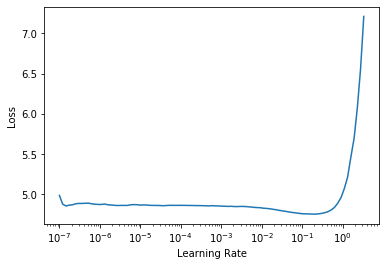

In [67]:
learn_lm.lr_find()

A learning rate of 1e-2 seem to be a safe choice:

In [68]:
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.189573,3.936918,0.315999,51.260372,02:35


Next we will unfreeze all layers and train for 10 epochs at a reduced learning rate. The idea is that once we unfreeze the lower layers of our model we should make smaller changes to avoid catastrophic forgetting. We will go for a leraning rate of 1e-3. One can always test if longer training improves results, but in this case we will simply assumes that 10 epochs is good enough.

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=6.309573450380412e-07)

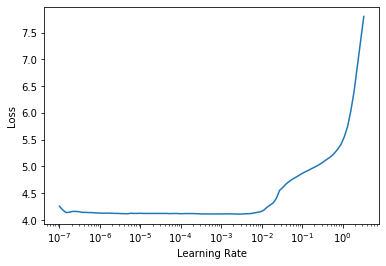

In [69]:
learn_lm.unfreeze()
learn_lm.lr_find()

In [70]:
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.997230,3.822397,0.327288,45.713673,02:47
1,3.954266,3.777179,0.330856,43.692589,02:48
2,3.878042,3.725606,0.337251,41.496380,02:38
3,3.814440,3.686008,0.340614,39.885315,02:47
4,3.785215,3.656684,0.344700,38.732697,02:41
5,3.729483,3.635671,0.346845,37.927280,02:43
6,3.698734,3.618694,0.348383,37.288837,02:46
7,3.654537,3.607326,0.350624,36.867321,02:48
8,3.635801,3.602736,0.351033,36.698505,02:49
9,3.618312,3.601928,0.351133,36.668865,02:50


> Note: We're only training for about 30 minutes on a single GPU.

We will save the model and the encoder for future use. The `save()` method save objects to path/'models' by default. The encoder will be used in our classifier in the next post.

In [71]:
learn_lm.save('finetuned_model')
learn_lm.save_encoder('finetuned_encoder')

Is the model any good at predicting text?

In [72]:
TEXT = "Denne filmen er et godt eksempel på" # this film is a good example of
preds = [learn_lm.predict(TEXT, 40, temperature=0.75) for _ in range(3)]
preds

['xxunk denne filmen er et godt eksempel på hvordan serien er blitt laget med en amerikansk komedie . i filmen står det en tydelig og effektiv følelse av at en serie med tretten mennesker , som har mistet kontrollen over de to første episodene , har fått en',
 'xxunk denne filmen er et godt eksempel på hva som skjer når den kommer i nærheten av en tsunami . i verste fall skjer det med den virkelige verden , hvor det som skjer , er det som gjør at den blir rammet av et stadig forvirrende ,',
 'xxunk denne filmen er et godt eksempel på at det er vanskelig å forestille seg hva som egentlig foregår . i visse scener er dette en underholdende og ytterst underholdende film , i norsk forstand . JON GORE « the THAT IN']

This is by no means as impressive as the recent transformer models, but the model certainly understands language fairly well. Also, our particular use case isn't really text generation, but sentiment classification. Transformers only do marginally better than ULMFiT according to [Papers with code](https://paperswithcode.com/sota/sentiment-analysis-on-imdb) on the similar IMDB classification task. Classification will be the topic of an upcoming post.